In [3]:
import numpy as np
from nilearn import image, plotting
import nibabel as nib
from glob import glob as glob

In [4]:
roi_dir = '/user_data/vayzenbe/GitHub_Repos/fmri/roiParcels'
parcel_dir = '/user_data/vayzenbe/GitHub_Repos/fmri/roiParcels/mruczek_parcels'
og_mni =image.load_img('/opt/fsl/6.0.3/data/standard/MNI152_T1_1mm_brain.nii.gz')
og_affine = og_mni.affine
new_mni= image.load_img('/opt/fsl/6.0.3/data/standard/MNI152_T1_2mm_brain.nii.gz')
new_affine = new_mni.affine


parcel_files= glob(f'{parcel_dir}/subj_vol_all/*')


In [5]:
'''
Add Julian parcels to ventral mask
'''

#load ventral mask
ventral_mask = image.load_img(f'{parcel_dir}/binary/ventral_visual_cortex.nii.gz')
#define julian parcels
julian_dir = f'/user_data/vayzenbe/GitHub_Repos/fmri/roiParcels/julian_parcels'
rois = ['lLO','rLO','lPFS','rPFS', 'lPPA','rPPA']

#loops through rois and combines them into one mask
for roi in rois:
    curr_roi = image.load_img(f'{julian_dir}/{roi}.nii.gz')

    #resample to 2mm
    curr_roi = image.resample_to_img(curr_roi, new_mni, interpolation='nearest')

    #add to ventral mask
    ventral_mask = image.math_img('a+b', a=ventral_mask, b=curr_roi)


#binarize ventral mask
ventral_mask = image.math_img('a>0', a=ventral_mask)
#save ventral mask
nib.save(ventral_mask,'/user_data/vayzenbe/GitHub_Repos/fmri/roiParcels/ventral_visual_cortex.nii.gz')

'''
in terminal then do to fill holes:
fslmaths ventral_visual_cortex.nii.gz -fillh ventral_visual_cortex.nii.gz
'''

'\nin terminal then do to fill holes:\nfslmaths ventral_visual_cortex.nii.gz -fillh ventral_visual_cortex.nii.gz\n'

In [7]:
'''
Add Julian parcels to dorsal mask
'''

#load ventral mask
dorsal_mask = image.load_img(f'{parcel_dir}/binary/dorsal_visual_cortex.nii.gz')
#define julian parcels
julian_dir = f'/user_data/vayzenbe/GitHub_Repos/fmri/roiParcels/julian_parcels'
rois = ['lOPA','rOPA']

#loops through rois and combines them into one mask
for roi in rois:
    curr_roi = image.load_img(f'{julian_dir}/{roi}.nii.gz')

    #resample to 2mm
    curr_roi = image.resample_to_img(curr_roi, new_mni, interpolation='nearest')

    #add to ventral mask
    dorsal_mask = image.math_img('a+b', a=dorsal_mask, b=curr_roi)


#binarize ventral mask
dorsal_mask = image.math_img('a>0', a=dorsal_mask)
#save ventral mask
nib.save(dorsal_mask,'/user_data/vayzenbe/GitHub_Repos/fmri/roiParcels/dorsal_visual_cortex.nii.gz')

'''
in terminal then do to fill holes:
fslmaths dorsal_visual_cortex.nii.gz -fillh dorsal_visual_cortex.nii.gz
'''

'\nin terminal then do to fill holes:\nfslmaths dorsal_visual_cortex.nii.gz -fillh dorsal_visual_cortex.nii.gz\n'

In [41]:
#subtract dorsal from ventral mask
dorsal = image.load_img(f'{roi_dir}/dorsal_visual_cortex.nii.gz')
ventral = image.load_img(f'{roi_dir}/ventral_visual_cortex.nii.gz')

ventral = image.math_img('a-b', a=ventral, b=dorsal)
#binarize ventral mask
ventral = image.math_img('a>0', a=ventral)

In [42]:
#convert to numpy
ventral_np = ventral.get_fdata()

#0 voxels above the midline in the z direction
ventral_np[:,:,40:] = 0

#convert back to nifti
ventral_cut = nib.Nifti1Image(ventral_np, affine=new_affine)
#binarize
ventral_cut = image.math_img('a>0', a=ventral_cut)

#save
nib.save(ventral_cut,f"{roi_dir}/ventral_visual_cortex.nii.gz")


/home/vayzenbe/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/vayzenbe/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "
/home/vayzenbe/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



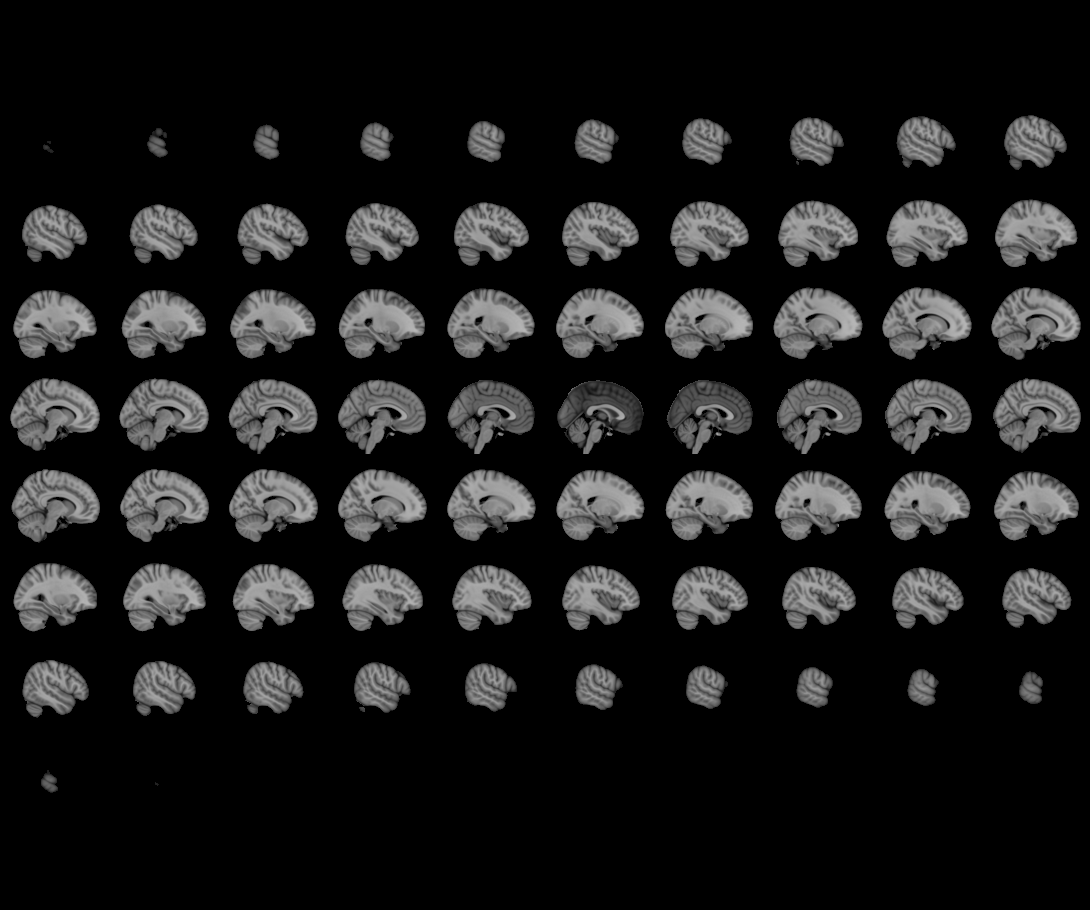
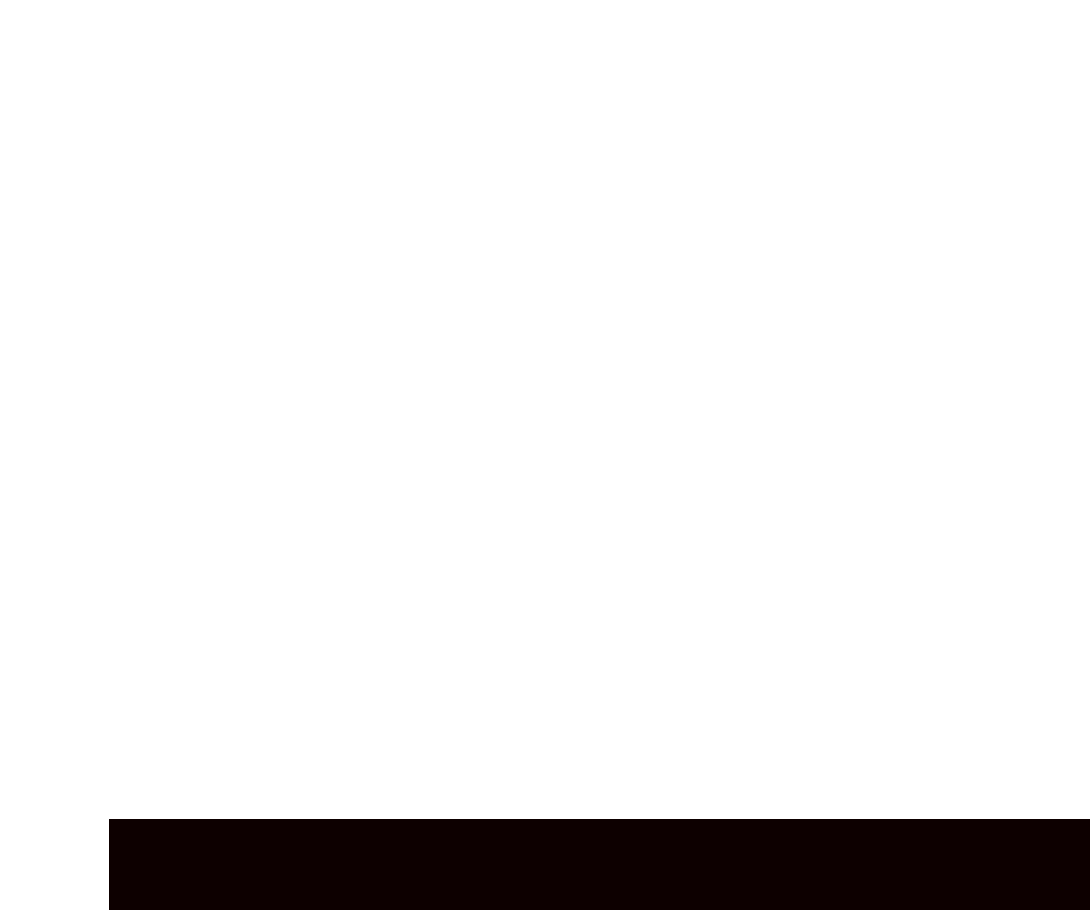

In [45]:
ventral = image.load_img(f'{roi_dir}/ventral_visual_cortex.nii.gz')
dorsal = image.load_img(f'{roi_dir}/dorsal_visual_cortex.nii.gz')

combined = image.math_img('a+b', a=ventral, b=dorsal)
plotting.view_img(combined, bg_img=new_mni)

In [6]:
'''
create mask of all visual areas
'''
all_mask = np.zeros(og_mni.shape)
for ii in parcel_files:
    
    curr_file =image.get_data(image.load_img(ii))
    curr_file[curr_file[:,:,:] >0] = 1

    all_mask = all_mask + curr_file

all_mask[all_mask[:,:,:] >0] = 1
all_mask[all_mask[:,:,:]!=1] = 0
nib.save(all_mask, f'{parcel_dir}/binary/all_visual_areas.nii.gz')  # Save the volume

In [3]:
"""
Make ventral mask
"""
roi_path = '/user_data/vayzenbe/GitHub_Repos/fmri/roiParcels/mruczek_parcels/subj_vol_all/perc_VTPM_vol_roi'
roi_num = [7,8,9,10,11,14,15]
all_mask = np.zeros(og_mni.shape)
for lr in ['l','r']:
    for rr in roi_num:
        roi = f'{roi_path}{rr}_{lr}h.nii.gz'
        curr_file =image.get_data(image.load_img(roi))
        curr_file[curr_file[:,:,:] >0] = 1

        all_mask = all_mask + curr_file

    all_mask[all_mask[:,:,:] >0] = 1
    all_mask[all_mask[:,:,:]!=1] = 0


all_masks = nib.Nifti1Image(all_mask, og_affine)
#all_masks = image.resample_to_img(all_masks, new_mni)

all_masks = image.resample_to_img(all_masks, new_mni, interpolation='nearest')
print(all_masks.shape)
nib.save(all_masks, f'{parcel_dir}/binary/ventral_visual_cortex.nii.gz')  # Save the volume

(91, 109, 91)


In [7]:
ventral_mask = image.load_img(f'{parcel_dir}/binary/test.nii.gz')
plotting.plot_roi(ventral_mask, bg_img=new_mni)

ValueError: File not found: '/user_data/vayzenbe/GitHub_Repos/fmri/roiParcels/mruczek_parcels/binary/test.nii.gz'

/home/vayzenbe/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/vayzenbe/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "



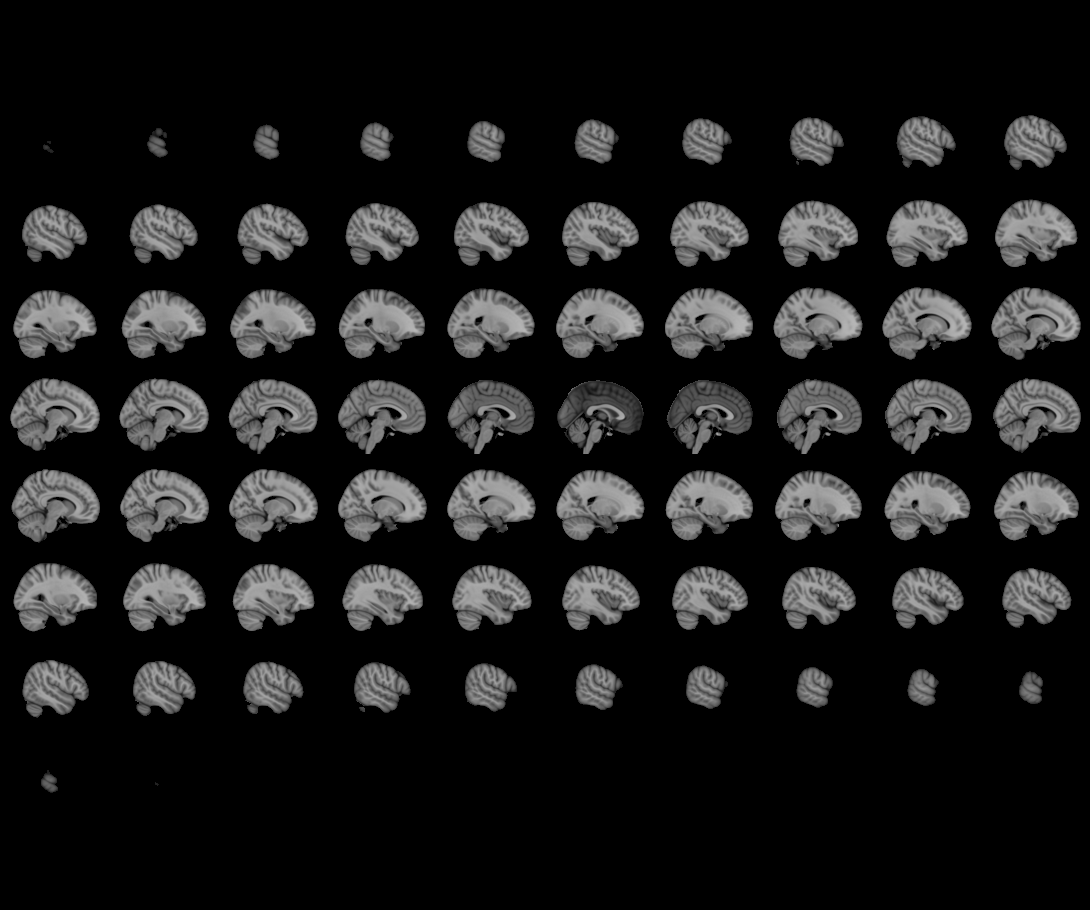
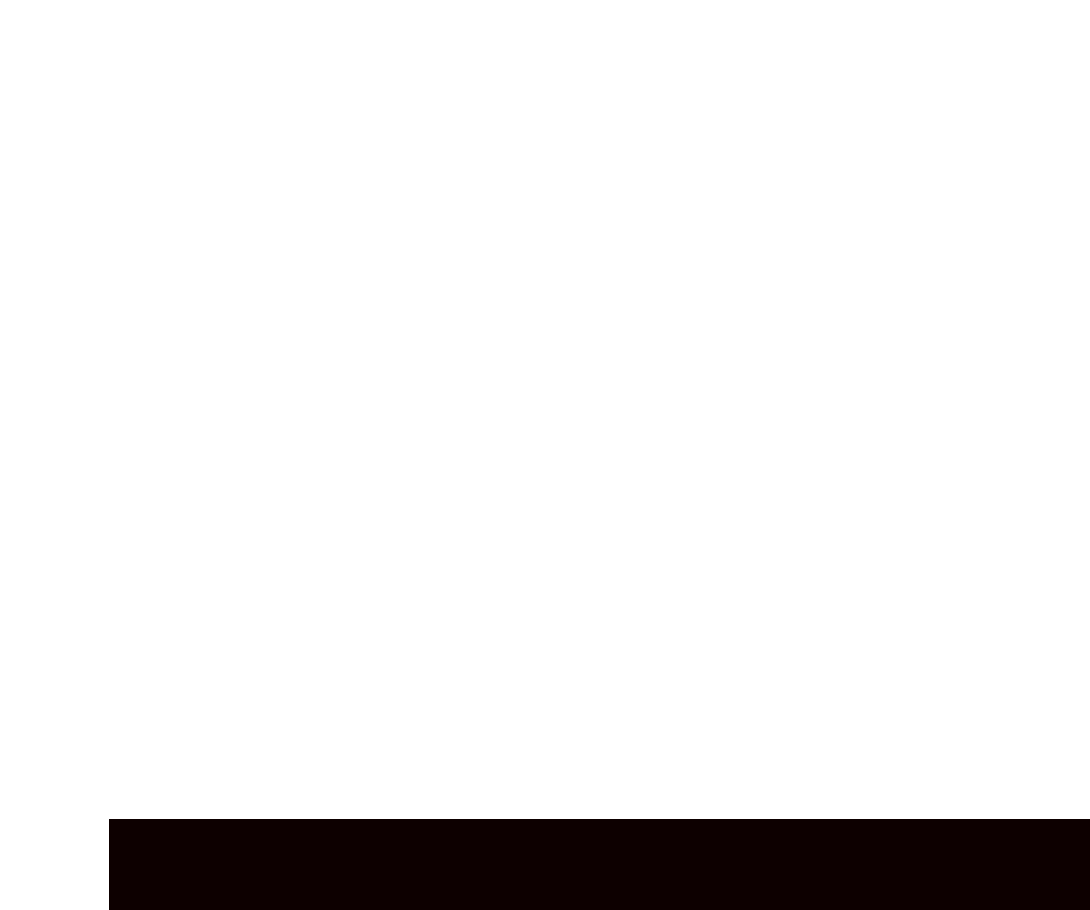

In [9]:
ventral_mask = image.load_img('/user_data/vayzenbe/GitHub_Repos/fmri/roiParcels/ventral_visual_cortex.nii.gz')
#plotting.plot_roi(ventral_mask, bg_img=new_mni)
plotting.view_img(ventral_mask, bg_img=new_mni)

In [7]:
"""
Make dorsal mask
"""
roi_path = '/user_data/vayzenbe/GitHub_Repos/fmri/roiParcels/mruczek_parcels/subj_vol_all/perc_VTPM_vol_roi'
roi_num = [16, 17, 18, 19, 20, 21, 22, 23, 24]
all_mask = np.zeros(og_mni.shape)
for lr in ['l','r']:
    for rr in roi_num:
        roi = f'{roi_path}{rr}_{lr}h.nii.gz'
        curr_file =image.get_data(image.load_img(roi))
        curr_file[curr_file[:,:,:] >0] = 1

        all_mask = all_mask + curr_file

    all_mask[all_mask[:,:,:] >0] = 1
    all_mask[all_mask[:,:,:]!=1] = 0


all_masks = nib.Nifti1Image(all_mask, og_affine)
#all_masks = image.resample_to_img(all_masks, new_mni)

all_masks = image.resample_to_img(all_masks, new_mni, interpolation='nearest')
print(all_masks.shape)
nib.save(all_masks, f'{parcel_dir}/binary/dorsal_visual_cortex.nii.gz')  # Save the volume

(91, 109, 91)


/home/vayzenbe/anaconda3/envs/fmri_new/lib/python3.8/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "



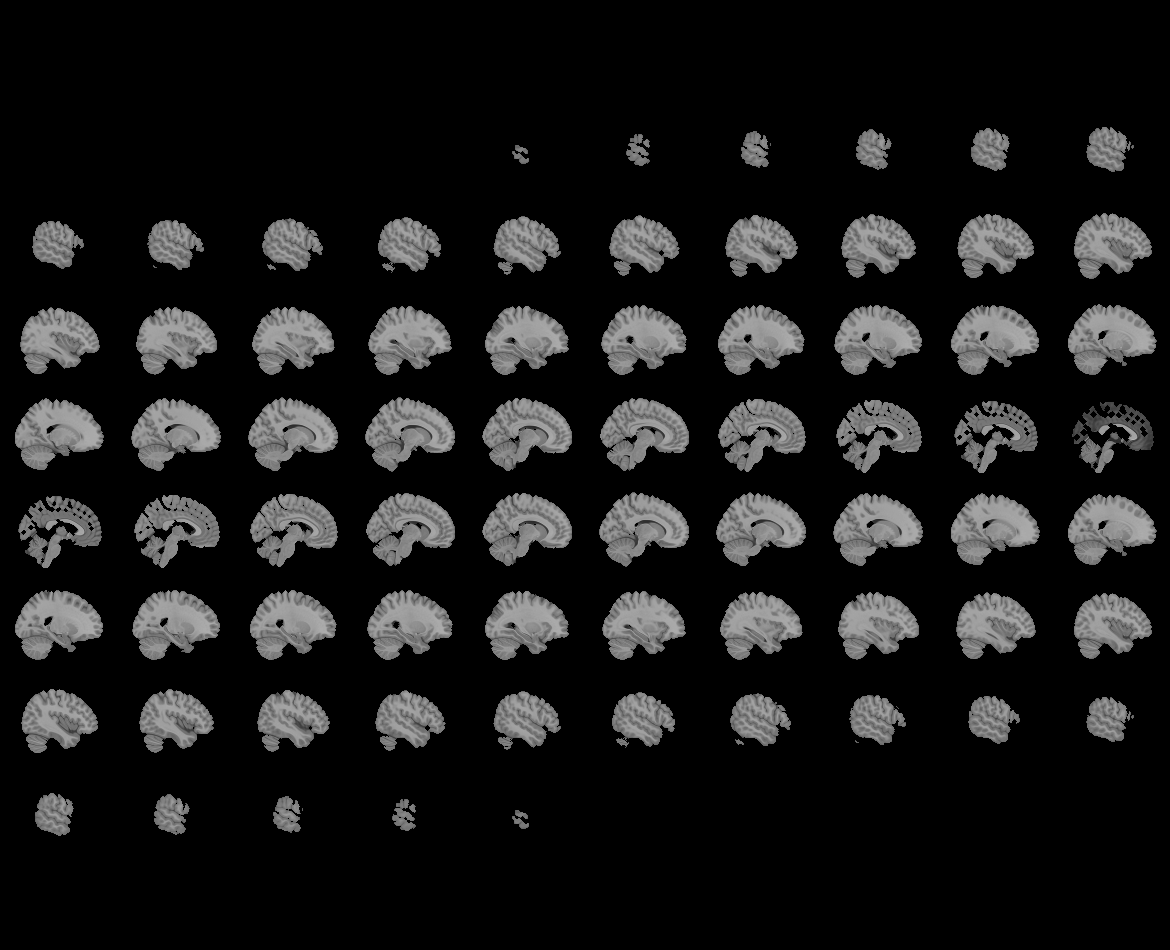
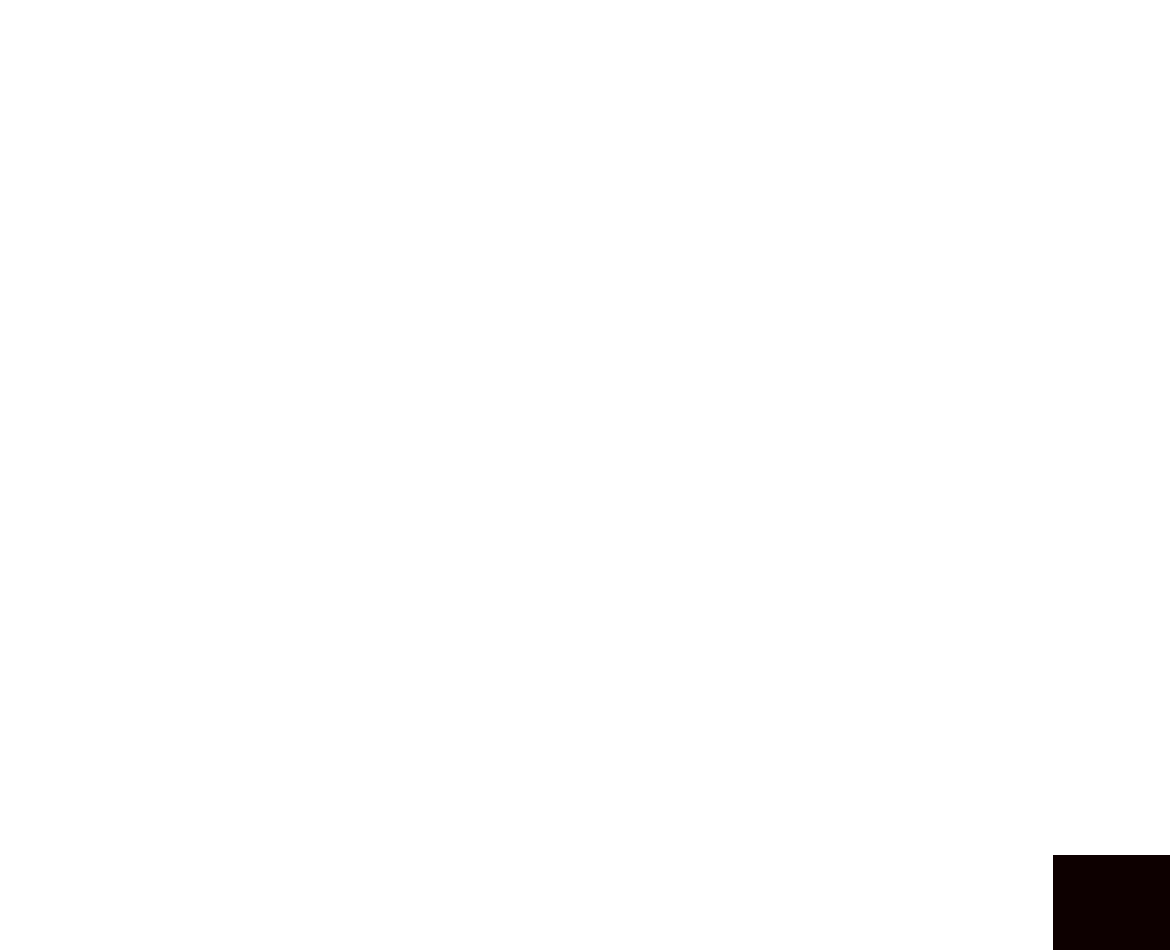

In [8]:
plotting.view_img(all_masks)


In [ ]:
#subtract dorsal mask from ventral mask
#load dorsal mask
dorsal_mask = image.load_img(f'{parcel_dir}/binary/dorsal_visual_cortex.nii.gz')
#load ventral mask

In [27]:
'''Make ventral mask from julian parcels'''


julian_dir = '/user_data/vayzenbe/GitHub_Repos/fmri/roiParcels/julian_parcels'
ventral_rois = ['LO','PFS','FFA','OFA','PPA']

all_mask = np.zeros(og_mni.shape)
for lr in ['l','r']:
    for roi in ventral_rois:
        roi = f'{julian_dir}/{lr}{roi}.nii.gz'
        curr_file =image.get_data(image.load_img(roi))
        curr_file[curr_file[:,:,:] >0] = 1

        all_mask = all_mask + curr_file


        #all_masks = image.resample_to_img(all_masks, new_mni)


all_mask[all_mask[:,:,:] >0] = 1
all_mask[all_mask[:,:,:]!=1] = 0
all_masks = nib.Nifti1Image(all_mask, og_affine)
all_masks = image.resample_to_img(all_masks, new_mni)
#save to julia dir
nib.save(all_masks, f'{julian_dir}/ventral_visual_cortex.nii.gz')  # Save the volume

/home/vayzenbe/anaconda3/envs/fmri_new/lib/python3.8/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


In [36]:
#load mruczek ventral mask
ventral_roi = image.get_data(image.load_img(f'{parcel_dir}/binary/ventral_visual_cortex.nii.gz'))
#load julian ventral mask
julian_ventral_roi = image.get_data(image.load_img(f'{julian_dir}/ventral_visual_cortex.nii.gz'))

#add them together then binarize
all_mask = ventral_roi + julian_ventral_roi
all_mask[all_mask[:,:,:] >0] = 1

#save to mruczek dir
all_masks = nib.Nifti1Image(all_mask, new_affine)
nib.save(all_masks, f'{parcel_dir}/binary/ventral_visual_cortex.nii.gz')  # Save the volume

In [29]:
#subtract dorsal from ventral roi
ventral_roi =image.get_data(image.load_img(f'{parcel_dir}/binary/ventral_visual_cortex.nii.gz'))

dorsal_roi =image.get_data(image.load_img(f'{parcel_dir}/binary/dorsal_visual_cortex.nii.gz'))

#subtract dorsal from ventral roi
ventral_roi =ventral_roi - dorsal_roi

#set negative values to zero
ventral_roi[ventral_roi[:,:,:] <0] = 0
ventral_roi = nib.Nifti1Image(ventral_roi, new_affine)
nib.save(ventral_roi, f'{parcel_dir}/binary/ventral_visual_cortex.nii.gz')  # Save the volume